In [1]:
import PIL
import geopandas as gpd
import shapely
import rasterio
import numpy as np
import scipy as sp
import cv2 as cv2
import skimage as sk
import matplotlib.pyplot as plt
import itertools
import pickle
from matplotlib.colors import LinearSegmentedColormap
import json



In [2]:
# Set global font size
plt.rc('font', size=11)          # Default text size

# Set specific font sizes for plot elements
plt.rc('axes', titlesize=6)     # Axes title font size
plt.rc('axes', labelsize=6)     # Axes labels font size
plt.rc('xtick', labelsize=6)    # X-axis tick labels font size
plt.rc('ytick', labelsize=6)    # Y-axis tick labels font size
plt.rc('legend', fontsize=6)    # Legend font size
plt.rc('figure', titlesize=9)  

Lets load the pickled data from the preprocessing

In [4]:
# Load the pickle data
with open("../data/processed/pickled_dataset.pkl" , 'rb') as file:
    pickled_data = pickle.load(file)

## Data

here we will make a figure showing the raw images that where used in the analysis along with, some of the constructed covariates

| nucleus channel|  mt channel| er channel |

|peroxisome channel  | distance map   |  mt contact |
___ the whole data set __
mixed of all 


In [5]:
scale = pickled_data["scale"]

def imshow(ax,image):
    xlength = image.shape[1]/scale
    ylength = image.shape[0]/scale
    ax.imshow(image, cmap='binary',origin = "lower",extent = (0,xlength,0,ylength))
 #   ax.plot([xlength-15,xlength-5],[0.05*ylength,0.05*ylength],color = "black")
#    ax.text(s = r"$10\mathrm{\mu m}$",x = xlength-10, y = 0.07*ylength,horizontalalignment = "center")
    ax.set_xticks([])
    ax.set_yticks([])


def multiplot(dataset_dictionary, cells, imagesets, imagesubsets):

    combinations = list(itertools.product(cells, imagesets, imagesubsets))
    number_of_images = len(combinations)
    
    ncols = 3
    nrows = int(np.ceil(number_of_images / ncols))

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))
    axes = axes.flatten()

    # Plot each image
    for idx, keys in enumerate(combinations):
        cell,set,subset = keys
        ax = axes[idx]
        image = dataset_dictionary[cell][set][subset]
        imshow(ax,image)
        ax.set_title(f"{cell}/{set}/{subset}",fontsize = 8)
    # Hide any unused subplots
    for idx in range(number_of_images, nrows * ncols):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    plt.show()


In [6]:
import numpy as np

def combine_colorized_images_white_bg(images, colors):
    """
    Combines a list of grayscale images with specified colors into a single colored image on a white background.

    Parameters:
    images (list of 2D numpy arrays): List of grayscale images.
    colors (list of tuples): List of RGB tuples (each component between 0 and 1) corresponding to each image.

    Returns:
    combined_image (numpy array): The combined RGB image on a white background.
    """
    if len(images) != len(colors):
        raise ValueError("The number of images must match the number of colors.")

    # Ensure all images are numpy arrays and normalize them
    normalized_images = []
    for img in images:
        img = np.array(img, dtype=np.float32)
        max_val = img.max()
        img /= max_val if max_val != 0 else 1  # Normalize to [0, 1]
        normalized_images.append(img)

    # Initialize the combined image with a white background
    height, width = normalized_images[0].shape
    combined_image = np.ones((height, width, 3), dtype=np.float32)  # White background

    # Overlay each colorized image onto the combined image
    for img, color in zip(normalized_images, colors):
        # Validate color
        if len(color) != 3:
            raise ValueError("Each color must be a tuple with three components (R, G, B).")
        if any(c < 0 or c > 1 for c in color):
            raise ValueError("Color components must be between 0 and 1.")

        # Create the colorized image
        colorized_img = np.stack([img * c for c in color], axis=-1)

        # Create an alpha mask
        alpha = np.expand_dims(img, axis=-1)  # Alpha channel based on image intensity

        # Composite the colorized image onto the combined image
        combined_image = alpha * colorized_img + (1 - alpha) * combined_image

    # Clip values to [0, 1] range
    combined_image = np.clip(combined_image, 0, 1)

    return combined_image


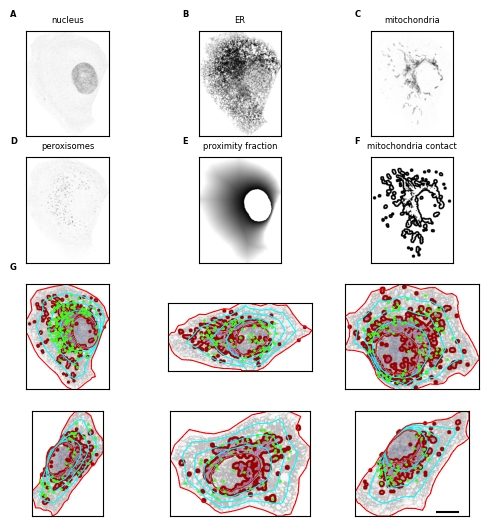

In [17]:
def plot_all(ax,cell):

    data = pickled_data[cell]
    
    images = [data["raw"]["nucleus"],data["raw"]["ER"],data["raw"]["mitochondria"],data["proximity"]["mitochondria"]]
    colors = [
        (0, 0, 1),  
        (1, 1, 1), 
        (1, 0, 1),
        (0.6, 0, 0)
    ]
    

    
    img = combine_colorized_images_white_bg(images,colors)
    #fig, main_ax = plt.subplots(figsize=(15/2.54,14/ 2.54))        
    imshow(ax,img)
    
    
    contour_levels = [ 0.25, 0.5, 0.75]
    
    # Add contour lines
    contours = ax.contour(data["distance"]["fractional distance"], levels=contour_levels, colors='cyan', linewidths=0.75,extent = (0,data["distance"]["fractional distance"].shape[1]/scale,0,data["distance"]["fractional distance"].shape[0]/scale))
    ax.plot(
        data["contours"]["cell"][:,0],
        data["contours"]["cell"][:,1],
        color="red",linewidth = 0.75)
    
    ax.plot(
        data["contours"]["nucleus"][:,0],
        data["contours"]["nucleus"][:,1],
        color="red",linewidth = 0.75)

    ax.scatter(data["point patterns"]["peroxisomes"][0],data["point patterns"]["peroxisomes"][1],color = "#39FF14",s =1,zorder = 10)


#fig, main_ax = plt.subplots((5,5)figsize=(15/2.54,14/ 2.54))        



fig, axs = plt.subplots(nrows = 4, ncols = 3,figsize=(16/2.54,16/ 2.54))



#main_ax.axis('off')

imshow(axs[0,0],pickled_data["cell1"]["raw"]["nucleus"])
imshow(axs[0,1],pickled_data["cell1"]["raw"]["ER"])
imshow(axs[0,2],pickled_data["cell1"]["raw"]["mitochondria"])
imshow(axs[1,0],pickled_data["cell1"]["raw"]["peroxisomes"])
imshow(axs[1,1],pickled_data["cell1"]["distance"]["fractional distance"])
imshow(axs[1,2],pickled_data["cell1"]["proximity"]["mitochondria"])

axs[3,2].plot([40,50],[ 2,2],color ="black")

plot_all(axs[2,0],"cell1")
plot_all(axs[2,1],"cell2")
plot_all(axs[2,2],"cell3")
plot_all(axs[3,0],"cell4")
plot_all(axs[3,1],"cell5")
plot_all(axs[3,2],"cell6")

#for i in [0,1,2,3]:
 #   for j in [0,1,2]:
 #       axs[i,j].axis("off")


axs[0,0].set_title("nucleus",size = 6)
axs[0,1].set_title("ER",size = 6)
axs[0,2].set_title("mitochondria",size = 6)

axs[1,0].set_title("peroxisomes",size = 6)
axs[1,1].set_title("proximity fraction",size = 6)
axs[1,2].set_title("mitochondria contact",size = 6)


#axs[2,1].set_title("data set",size = 6)


dx = -0.2
axs[0,0].text(dx, 1.2, "A", transform=axs[0,0].transAxes,
            fontsize=6, fontweight='bold', va='top', ha='left')

axs[0,1].text(dx, 1.2, "B", transform=axs[0,1].transAxes,
            fontsize=6, fontweight='bold', va='top', ha='left')

axs[0,2].text(dx, 1.2, "C", transform=axs[0,2].transAxes,
            fontsize=6, fontweight='bold', va='top', ha='left')

axs[1,0].text(dx, 1.2, "D", transform=axs[1,0].transAxes,
            fontsize=6, fontweight='bold', va='top', ha='left')



axs[1,1].text(dx, 1.2, "E", transform=axs[1,1].transAxes,
            fontsize=6, fontweight='bold', va='top', ha='left')



axs[1,2].text(dx, 1.2, "F", transform=axs[1,2].transAxes,
            fontsize=6, fontweight='bold', va='top', ha='left')

axs[2,0].text(dx, 1.2, "G", transform=axs[2,0].transAxes,
            fontsize=6, fontweight='bold', va='top', ha='left')
plt.savefig("../figures/data.pdf",bbox_inches='tight', pad_inches=0,dpi = 400)


## Results

we make a figure to summarize the results of our baysian inference. In the figure we will plot
- the marginal posterior distribution of the parameters for each covariate
- the marginal posterior distributions characterizing the GRF, so its range $\rho$ and its standard deviation $\sigma$
- the mean random field predicted sampled by the joint posterior distribution for one cell and the mean density predicted by the model 


we start by reading the posterior distributions and we add to the dictionary a characteristic color for each and a label

In [7]:
# Path to the combined JSON file
path_to_data = '../data/output/'  # Replace with your actual file path

# Load JSON data
with open(path_to_data + 'marginals.json', 'r') as f:
    marginals = json.load(f)

# assign unique colors to each
marginals["intercept"]["color"] = "lightgrey"
marginals["proximity fraction"]["color"] = "#09edecff"
marginals["er"]["color"] = "#767676cc"
marginals["mitochondria"]["color"] = "#ec45f288"
marginals["mitochondria proximity"]["color"] = "orange"
marginals["range"]["color"] = "blue"
marginals["standard deviation"]["color"] = "blue"

mean_density = dict()
with rasterio.open("../data/output/predicted_mean_density.tif") as src:
    mean_density_data = src.read()  # data.shape = (bands, rows, cols)
    layer_names = ["mean", "sd", "q0.025", "q0.5", "q0.975", "median", "mean.mc_std_err", "sd.mc_std_err"]
    for img,name in zip(mean_density_data,layer_names):
        img= np.copy(img)
        img[img <  -100000] = np.nan
        mean_density[name] = img

    height, width = mean_density_data[0].shape
    transform = src.transform  # Get the affine transform

    # Compute the spatial bounds
    left = transform.c
    right = transform.c + transform.a * width
    top = transform.f
    bottom = transform.f + transform.e * height
    
    mean_density["extent"] = [left, right, bottom, top]
    

random_field = dict()

with rasterio.open("../data/output/predicted_random_field.tif") as src:
    random_field_data = src.read()  # data.shape = (bands, rows, cols)
    layer_names = ["mean", "sd", "q0.025", "q0.5", "q0.975", "median", "mean.mc_std_err", "sd.mc_std_err"]
    for img,name in zip(random_field_data,layer_names):
        img= np.copy(img)
        img[img <  -100000] = np.nan
        random_field[name] = img
    transform = src.transform  # Get the affine transform

    height, width = random_field_data[0].shape
    
    # Compute the spatial bounds
    left = transform.c
    right = transform.c + transform.a * width
    top = transform.f
    bottom = transform.f + transform.e * height
    
    random_field["extent"] = [left, right, bottom, top]



we will plot them as violin plots, which allowes us to see still the shape of the distributions and make easy comparison among them


In [8]:
def plot_marginal_violin_vertical(ax,shift,marginal):

    color = marginal["color"]
    posterior = np.array(marginal["pdf"])
    x = posterior[:,0]
    y = posterior[:,1]/np.max(posterior[:,1])

    ax.plot( y+shift, x,color = "black",linewidth = 1)
    ax.plot( shift-y,x,color = "black",linewidth = 1)

    ax.fill_betweenx(x, shift-y,shift+y, color= color, alpha=0.1,interpolate=True)

    summary = marginal["summary"][0]

    
    x_conf = x[np.searchsorted(x, summary['0.025quant']):np.searchsorted(x, summary['0.975quant'])]
    y_conf = y[np.searchsorted(x, summary['0.025quant']):np.searchsorted(x, summary['0.975quant'])]
    ax.fill_betweenx(x_conf, shift-y_conf,shift+y_conf, color=color, alpha=0.6,interpolate=True)

    ax.plot([shift - y[np.searchsorted(x, summary['mean'])],y[np.searchsorted(x, summary['mean'])]+shift],[summary['mean'],summary['mean']],color = "black",linewidth = 0.5)


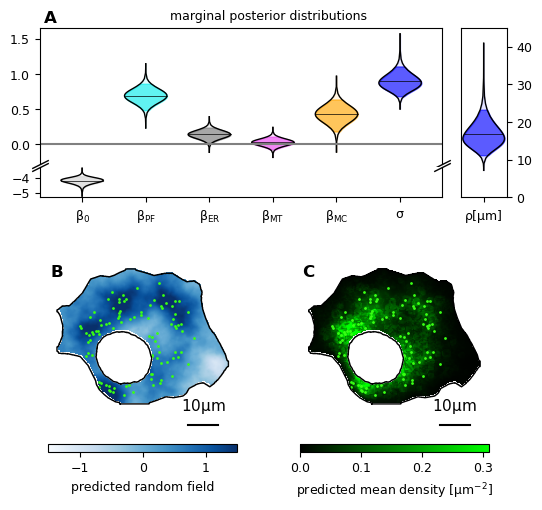

In [9]:
# now we add the marginals for the GRF

fig, main_ax = plt.subplots(figsize=(15/2.54,14/ 2.54))        

main_ax.axis('off')
marginals_ax = main_ax.inset_axes([0, 0.6,1, 0.4])


marginals_ax.axis('off')
marginals_ax.set_yticks([])
marginals_ax.set_xticks([])
marginals_ax.set_title("marginal posterior distributions")

ax1 = marginals_ax.inset_axes([0, 0,0.88, 1])
ax1.axis('off')
ax1.set_yticks([])
ax1.set_xticks([])

top_pannel = ax1.inset_axes([0, 0.2,1, 0.8])
bot_pannel = ax1.inset_axes([0 , 0, 1, 0.18])


plot_marginal_violin_vertical(bot_pannel,  0,marginals["intercept"])

for i,key in enumerate([ 'proximity fraction','er','mitochondria', 'mitochondria proximity', 'standard deviation']):    
    plot_marginal_violin_vertical(top_pannel,  3*(i+1),marginals[key])


top_pannel.plot([-3,18],[0,0],color = "grey")
bot_pannel.set_xticks([0,3,6,9,12,15])
bot_pannel.set_xticklabels([r"$\mathrm{\beta_0}$",r"$\mathrm{\beta_{PF}}$",r"$\mathrm{\beta_{ER}}$",r"$\mathrm{\beta_{MT}}$",r"$\mathrm{\beta_{MC}}$",r"$\mathrm{\sigma}$"])

top_pannel.set_xlim([-2,17])
bot_pannel.set_xlim([-2,17])

# hide the spines between ax and ax2
top_pannel.spines.bottom.set_visible(False)
bot_pannel.spines.top.set_visible(False)
top_pannel.set_xticks([])
#top_pannel.xaxis.tick_top()
top_pannel.tick_params(labeltop=False)  # don't put tick labels at the top
bot_pannel.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
top_pannel.plot([0, 1], [0, 0], transform=top_pannel.transAxes, **kwargs)
bot_pannel.plot([0, 1], [1, 1], transform=bot_pannel.transAxes, **kwargs)

ax2 = marginals_ax.inset_axes([0.92, 0,0.1, 1])
plot_marginal_violin_vertical(ax2, 0,marginals["range"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xticks([0])
ax2.set_xticklabels([r"$\mathrm{\rho[\mu m]}$"])
ax2.set_ylim([0,45])
from mpl_toolkits.axes_grid1 import make_axes_locatable



padding = 0.05

top_pad = 0.05
# First image and colorbar
grf_ax = main_ax.inset_axes([0, 0, 0.5 -padding, 0.5-top_pad])
im2 = grf_ax.imshow(random_field["mean"], cmap="Blues", extent=random_field["extent"],vmin=-1.5,vmax=1.5)

# Create a divider for grf_ax
divider = make_axes_locatable(grf_ax)
# Append a new axes for the colorbar
cax = divider.append_axes("bottom", size="5%", pad=0.1)
# Add the colorbar to the new axes
cbar = plt.colorbar(im2, cax=cax, orientation='horizontal')
cbar.set_label(r'predicted random field')

# Additional plotting on grf_ax
grf_ax.plot([170 - 15, 170 - 5], [85, 85], color="black")
grf_ax.text(s=r"$10\mathrm{\mu m}$", x=170 - 10, y=90, horizontalalignment="center")
grf_ax.scatter(
    pickled_data["cell3"]["point patterns"]["peroxisomes"][0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["point patterns"]["peroxisomes"][1] + 1000 / pickled_data["scale"],
    s=1, color="#39FF14"
)


grf_ax.plot(
    pickled_data["cell3"]["contours"]["nucleus"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["nucleus"][:,1] + 1000 / pickled_data["scale"],
    color="black",linewidth = 1)

grf_ax.plot(
    pickled_data["cell3"]["contours"]["cell"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["cell"][:,1] + 1000 / pickled_data["scale"],
    color="black",linewidth = 1)

grf_ax.fill( pickled_data["cell3"]["contours"]["nucleus"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["nucleus"][:,1] + 1000 / pickled_data["scale"], color='white') 



grf_ax.axis("off")

# Second image and colorbar
mean_density_ax = main_ax.inset_axes([0.5+ padding, 0, 0.5-padding, 0.5-top_pad])
black_to_green = LinearSegmentedColormap.from_list('BlackGreen',  [(0, 0, 0), (0, 1, 0)], N=256)
im = mean_density_ax.imshow(mean_density["mean"], cmap=black_to_green, extent=mean_density["extent"],vmin=0,vmax=0.31)

# Create a divider for mean_density_ax
divider = make_axes_locatable(mean_density_ax)
# Append a new axes for the colorbar
cax = divider.append_axes("bottom", size="5%", pad=0.1)
# Add the colorbar to the new axes
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'predicted mean density $\mathrm{[\mu m^{-2}]}$')

# Additional plotting on mean_density_ax
mean_density_ax.plot([170 - 15, 170 - 5], [85, 85], color="black")
mean_density_ax.text(s=r"$10\mathrm{\mu m}$", x=170 - 10, y=90, horizontalalignment="center")
mean_density_ax.scatter(
    pickled_data["cell3"]["point patterns"]["peroxisomes"][0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["point patterns"]["peroxisomes"][1] + 1000 / pickled_data["scale"],
    s=1, color="#39FF14"
)

mean_density_ax.plot(
    pickled_data["cell3"]["contours"]["nucleus"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["nucleus"][:,1] + 1000 / pickled_data["scale"],
    color="black",linewidth = 1)

mean_density_ax.plot(
    pickled_data["cell3"]["contours"]["cell"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["cell"][:,1] + 1000 / pickled_data["scale"],
    color="black",linewidth = 1)

mean_density_ax.fill( pickled_data["cell3"]["contours"]["nucleus"][:,0] + 1200 / pickled_data["scale"],
    pickled_data["cell3"]["contours"]["nucleus"][:,1] + 1000 / pickled_data["scale"], color='white') 

mean_density_ax.axis("off")

mean_density_ax.text(0.01, 0.98, "C", transform=mean_density_ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')


grf_ax.text(0.01, 0.98, "B", transform=grf_ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')
marginals_ax.text(0.01, 1.1, "A", transform =marginals_ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left',zorder=10)

plt.savefig("../figures/results.pdf",bbox_inches='tight', pad_inches=0)

